In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import folium
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from folium import plugins
from folium.plugins import HeatMap
from IPython.display import display

from collections import Counter
from imblearn.over_sampling import SMOTE

# Preprocessing

### Load tweets from csv file

In [68]:
df = pd.read_csv("agaton_leyte.csv", encoding='latin-1')

### Extract latitude and longitude from the coordinates column.

In [69]:
df['coordinates'] = df['coordinates'].str.replace("{'longitude':", "",regex=True)
df['coordinates'] = df['coordinates'].str.replace(", 'latitude':", "")
df['coordinates'] = df['coordinates'].str.replace("}", "", regex=True)
df['Longitude'] = df['coordinates'].str.split(' ', expand = True)[1]
df['Latitude'] = df['coordinates'].str.split(' ', expand = True)[2]

### Counts tweets in each rating

In [70]:
df['rating'].value_counts()

0    59
1    21
2    20
Name: rating, dtype: int64

### Split data into training data and testing data

In [71]:
X = df['content']
Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.50)

### Instantiate vectorizer and fit on the training data

In [72]:
# instantiate countfvectorizer
vect = CountVectorizer(analyzer = "word", ngram_range=(1, 2))

# fit on the training data, transform training and test data
train_data = vect.fit_transform(X_train)
test_data = vect.transform(X_test)
train_data = train_data.toarray()

print(train_data.shape)
print(test_data.shape)

(50, 1531)
(50, 1531)


### Create separate training data that uses SMOTE technique

In [73]:
counter = Counter(Y_train)
print('Before SMOTE:', counter)
strategy = {2:13}
smt = SMOTE(sampling_strategy=strategy)
train_data_sm, Y_train_sm = smt.fit_resample(train_data, Y_train)
counter2 = Counter(Y_train_sm)
print('After SMOTE:', counter2)

Before SMOTE: Counter({0: 29, 1: 13, 2: 8})
After SMOTE: Counter({0: 29, 1: 13, 2: 13})


# Comparing Models

### Using logistic regression model,

In [74]:
# Logistic Regression model
lr = LogisticRegression()

lr.fit(train_data, Y_train)

lr.fit(train_data, Y_train)
print("Accuracy score (training): {0:.3f}".format(lr.score(train_data, Y_train)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(lr.score(test_data, Y_test)))

# print predictions in test data
lr_pred = lr.predict(test_data)
print(lr_pred)

Accuracy score (training): 1.000
Accuracy score (testing): 0.760
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 0 2 0 1 0 0 0 0 2 0 0 0 0 0 2 0 0 2 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using logistic regression model (w/ SMOTE),

In [75]:
# Logistic Regression model
lr_sm = LogisticRegression()

lr_sm.fit(train_data_sm, Y_train_sm)

lr_sm.fit(train_data_sm, Y_train_sm)
print("Accuracy score (training): {0:.3f}".format(lr_sm.score(train_data_sm, Y_train_sm)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(lr_sm.score(test_data, Y_test)))

# print predictions in test data
lr_pred_sm = lr_sm.predict(test_data)
print(lr_pred_sm)

Accuracy score (training): 1.000
Accuracy score (testing): 0.700
[0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 2 1 0 2 2 1 0 0 0 2 2 0 1 0 0 2 2 2 2 2 0 1
 0 0 0 0 0 2 2 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model,

In [76]:
# Gradient Boosting Classifier model
gb = GradientBoostingClassifier()

gb.fit(train_data, Y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(train_data, Y_train)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(gb.score(test_data, Y_test)))

#print predictions in test data
gb_pred = gb.predict(test_data)
print(gb_pred)

Accuracy score (training): 1.000
Accuracy score (testing): 0.660
[0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Using Gradient Boosting Classifier model (w/ SMOTE),

In [77]:
# Gradient Boosting Classifier model
gb_sm = GradientBoostingClassifier()

gb_sm.fit(train_data_sm, Y_train_sm)
print("Accuracy score (training): {0:.3f}".format(gb_sm.score(train_data_sm, Y_train_sm)))

# accuracy score of model
print("Accuracy score (testing): {0:.3f}".format(gb_sm.score(test_data, Y_test)))

#print predictions in test data
gb_pred_sm = gb_sm.predict(test_data)
print(gb_pred_sm)

Accuracy score (training): 1.000
Accuracy score (testing): 0.620
[0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 2 0 0 0 0 1 0 1 0 2 2 0 0 0 0 2 2 0 2 0 0 0
 0 0 0 0 0 2 2 0 0 0 0 0 0]


### Get the accuracy and ROC AUC score of both models

In [78]:
print('--Gradient Boosting--')
print(f"Accuracy score: {accuracy_score(Y_test, gb_pred)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, gb.predict_proba(test_data), multi_class = 'ovr')}")
print('\n--Gradient Boosting w/ SMOTE--')
print(f"Accuracy score: {accuracy_score(Y_test, gb_pred_sm)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, gb_sm.predict_proba(test_data), multi_class = 'ovr')}")

--Gradient Boosting--
Accuracy score: 0.66
ROC AUC score: 0.8294329573934837

--Gradient Boosting w/ SMOTE--
Accuracy score: 0.62
ROC AUC score: 0.7473976608187135


In [79]:
print('--Linear Regression--')
print(f"Accuracy score: {accuracy_score(Y_test, lr_pred)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, lr.predict_proba(test_data), multi_class = 'ovr')}")
print('\n--Linear Regression w/ SMOTE--')
print(f"Accuracy score: {accuracy_score(Y_test, lr_pred_sm)}")
print(f"ROC AUC score: {roc_auc_score(Y_test, lr_sm.predict_proba(test_data), multi_class = 'ovr')}")

--Linear Regression--
Accuracy score: 0.76
ROC AUC score: 0.878874269005848

--Linear Regression w/ SMOTE--
Accuracy score: 0.7
ROC AUC score: 0.8134774436090226


### Choose the best model and save the predictions in wrongpred.csv. 
Logistic Regression was chosen because of its high accuracy and sufficient ROC AUC score.

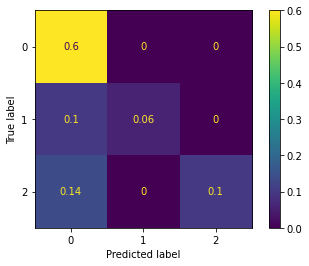

In [80]:
lr_cm = confusion_matrix(Y_test, lr_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm,display_labels=[0,1,2])
disp.plot()

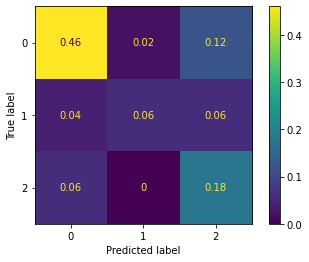

In [87]:
lr_sm_cm = confusion_matrix(Y_test, lr_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=lr_sm_cm,display_labels=[0,1,2])
disp.plot()

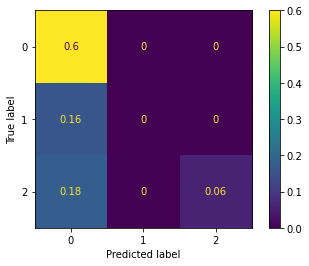

In [81]:
gb_cm = confusion_matrix(Y_test, gb_pred, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_cm,display_labels=[0,1,2])
disp.plot()

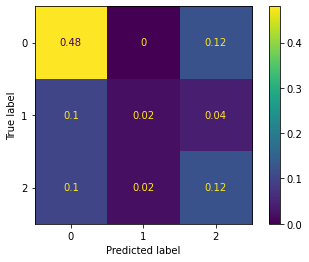

In [82]:
gb_sm_cm = confusion_matrix(Y_test, gb_pred_sm, labels=[0,1,2], normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=gb_sm_cm,display_labels=[0,1,2])
disp.plot()

In [83]:
# save predictions in csv file
wrong_pred = pd.DataFrame(X_test, columns =['content'])

wrong_pred.loc[:, 'coordinates'] = df['coordinates']
wrong_pred.loc[:, 'Latitude'] = df['Latitude']
wrong_pred.loc[:, 'Longitude'] = df['Longitude']
wrong_pred.loc[:, 'actual'] = Y_test
wrong_pred.loc[:, 'predicted'] = lr_pred
wrong_pred.loc[:, 'new_score'] = wrong_pred['actual'] + (4* wrong_pred['predicted'])
wrong_pred.head()

wrong_pred.to_csv("wrongpred.csv")

In [84]:
print(wrong_pred['new_score'].value_counts())

0     30
2      7
10     5
1      5
5      3
Name: new_score, dtype: int64


### Extract tweets with rank = 2

In [85]:
df_locs = pd.DataFrame(columns = ['Latitude', 'Longitude'])
df_locs['Latitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Latitude']
df_locs['Longitude'] = wrong_pred.loc[wrong_pred['predicted'] == 2, 'Longitude']

df_locs.head()

,Latitude,Longitude
39,10.5470262,124.7434968
12,10.5470262,124.7434968
15,11.0695902,124.6700376
47,10.5470262,124.7434968
93,10.9533981,124.4758848


### Plot the tweets in the geographical heatmap

In [86]:
fol_map = folium.Map(location=[10.847622263721211, 124.88887070186077], zoom_start=8)
markers = df_locs[['Latitude','Longitude']].values
fol_map.add_child(plugins.HeatMap(markers, radius=15))
fol_map